In [1]:
%matplotlib inline

import matplotlib.pyplot as plt; plt.rc('figure', dpi=150)
import random
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

data_path = '../../data/TfT/Experiment 1'

trajectories_file_name = 'all_mouse_data.csv'
instructions_screen_file_name = 'TfTMouse_InstructionScreen.csv'

# Preprocessing

In [3]:
traj_data = pd.read_csv(os.path.join(data_path, trajectories_file_name)).set_index(['participant', 'trial_no'])
choices_data = (pd.read_csv(os.path.join(data_path, instructions_screen_file_name))
                .rename(columns={'Pnum': 'participant', 'Trial': 'trial_no'})
                .set_index(['participant', 'trial_no']))

choices_data['is dwell tertile'] = pd.qcut(choices_data.DwellTime, q=3, labels=['Low', 'Medium', 'High'])

# we can also calculate tertiles within sub-groups of trials according to previous error type, but the resulting plot
# looks less coherent
# choices_data['is dwell tertile'] = choices_data.groupby(['previous_error'])['DwellTime'].transform(
#                      lambda x: pd.qcut(x, q=3, labels=['Low', 'Medium', 'High']))

In [4]:
def resample_trajectory(trajectory, n_steps=100):
    t_regular = np.linspace(trajectory.t.min(), trajectory.t.max(), n_steps + 1)
    x_interp = np.interp(t_regular, trajectory.t.values, trajectory.x.values)
    y_interp = np.interp(t_regular, trajectory.t.values, trajectory.y.values)
    traj_interp = pd.DataFrame([t_regular, x_interp, y_interp]).transpose()
    traj_interp.columns = ['t', 'x', 'y']

    return traj_interp

def apply_trajectory_resampling(dynamics):
    dynamics = dynamics.groupby(by=['participant', 'trial_no']).apply(resample_trajectory)
    dynamics = dynamics.reset_index(drop=False)
    dynamics = dynamics.drop(['level_2'], axis=1)
    dynamics = dynamics.set_index(['participant', 'trial_no'], drop=True)

    return dynamics

traj_data = apply_trajectory_resampling(traj_data)

In [5]:
traj_data = traj_data.join(choices_data.loc[:, ['previous_error', 'is dwell tertile']])

In [6]:
traj_data = traj_data[~(traj_data.previous_error=='NE')]
choices_data = choices_data[~(choices_data.previous_error=='NE')]

In [7]:
traj_data['is_leftward'] = traj_data.groupby(traj_data.index.names).last().x<0

Flip trajectories so that ME are all going to the left, and POE are all going to the right

In [8]:
traj_data.loc[(traj_data.previous_error=='ME') & (~traj_data.is_leftward), ['x']] *= -1
traj_data.loc[(traj_data.previous_error=='POE') & (traj_data.is_leftward), ['x']] *= -1

# Mean trajectories

In [9]:
def get_mean_trajectories(dynamics, variables):
    cols = dynamics.index.names + variables    
    dynamics_transposed = dynamics.groupby(by = cols). \
                    apply(lambda x: x.loc[:, ['x', 'y']].reset_index(drop=True).T)
    cols += ['x/y']
    dynamics_transposed.index.names = cols
    
    subj_mean_traj = dynamics_transposed.groupby(level=variables + ['x/y']).apply(np.mean).stack()
    
    subj_mean_traj.index.names = variables + ['x/y', 't']
    subj_mean_traj = subj_mean_traj.unstack('x/y')
    return subj_mean_traj

## Depending on previous error type

In [10]:
mean_traj = get_mean_trajectories(traj_data, ['previous_error'])
mean_traj = mean_traj.reset_index(drop=False)
mean_traj.loc[mean_traj.previous_error == 'ME', 'x'] *= -1
mean_traj = mean_traj.set_index('previous_error')

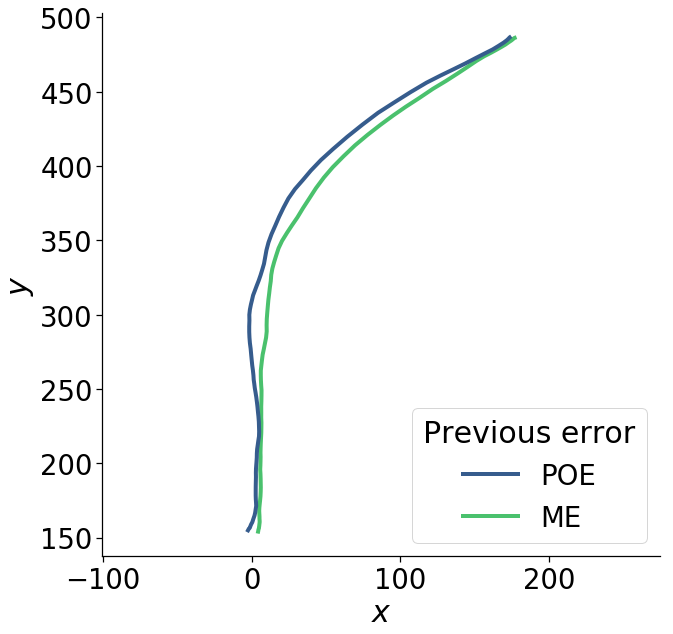

In [12]:
def plot_mean_trajectories(mean_trajectories):
    sns.set_palette('viridis')
    sns.set_context("notebook", font_scale=2.5)
    fig, ax = plt.subplots(1, figsize=(10, 10))

    ax.set_aspect(1, adjustable='datalim')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
    colors = {'POE': 'C1',
              'ME': 'C4'}

    for name, group in mean_trajectories.groupby(['previous_error']):
        ax.plot(mean_trajectories.loc[name].x, mean_trajectories.loc[name].y, 
                lw=4, color=colors[name])

    custom_lines = [Line2D([0], [0], color=color, lw=4) for color in colors.values()]

    ax.legend(custom_lines, colors.keys(), loc='lower right', title='Previous error')
    
    return ax

plot_mean_trajectories(mean_traj)
plt.savefig('mean_trajectories.png')

## Depending on is dwell

In [13]:
mean_traj = get_mean_trajectories(traj_data, ['previous_error', 'is dwell tertile'])

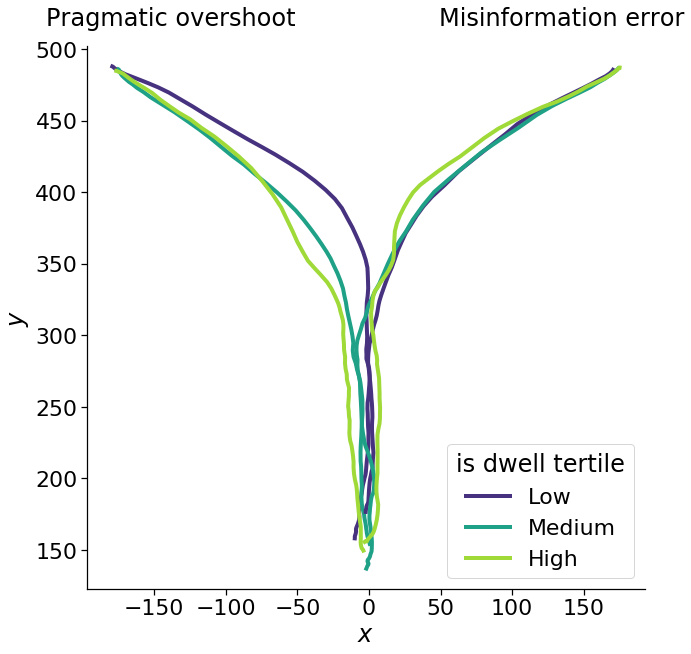

In [14]:
def plot_mean_trajectories(mean_trajectories, var):
    sns.set_palette('viridis')
    sns.set_context("notebook", font_scale=2)
    fig, ax = plt.subplots(1, figsize=(10, 10))

    ax.set_aspect(1, adjustable='datalim')
    colors = {'Low': 'C0',
              'Medium': 'C3',
              'High': 'C5'}
    
    for name, group in mean_trajectories.groupby(['previous_error', var]):
        ax.plot(mean_trajectories.loc[name].x, mean_trajectories.loc[name].y, 
                lw=4, color=colors[name[1]])
    ax.text(s='Misinformation error', x=0.85, y=1.05, 
            horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    ax.text(s='Pragmatic overshoot', x=0.15, y=1.05, 
            horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
    custom_lines = [Line2D([0], [0], color=color, lw=4) for color in colors.values()]

    ax.legend(custom_lines, ['Low', 'Medium', 'High'], loc='lower right', title='is dwell tertile')
    
    return ax

plot_mean_trajectories(mean_traj, var='is dwell tertile')

plt.savefig('mean_trajectories_by_is_dwell.png')

In [110]:
choices_data.groupby(['previous_error', 'is dwell tertile']).size()

previous_error  is dwell tertile
ME              Low                 149
                Medium              153
                High                148
POE             Low                 118
                Medium              152
                High                180
dtype: int64